In [169]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 300)
from textblob import TextBlob
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

### Read in Review Dataset

In [2]:
df = pd.read_csv('review_final.csv')

In [3]:
final_df = df[(~df['review_text'].isnull())]
final_df = final_df[(final_df['review_text'].apply(lambda x: len(x)>0))]

In [4]:
final_df['title'].nunique()

477

### Calculate Sentiment

In [5]:
final_df['sentiment'] = final_df['review_text'].apply(lambda x: TextBlob(x).polarity)

### Calculate length of review

In [6]:
final_df['review_length'] = final_df['review_text'].apply(lambda x: len(x))

In [7]:
final_df['list_date'] = pd.to_datetime(final_df['list_date']).apply(lambda x: x.timestamp())

In [57]:
filter_df = final_df[final_df['rank'] == final_df.groupby(['primary_isbn10'])['rank'].transform(max)]

In [58]:
len(filter_df)

1325

### Fit Regression Model and Get R^2 and Adjusted R^2

In [216]:
model_df = filter_df[['rank', 
                      'weeks_on_list',
                      'publisher',
                      'list_title',
                      'sentiment']]

df_dummy = pd.get_dummies(model_df, 
                          drop_first=False, 
                          columns=['publisher',
                                   'list_title'])

stats_model = LinearRegression(fit_intercept=True, 
                               normalize=True)
X = df_dummy.drop(labels=['rank'],
                  axis=1)
y = df_dummy['rank'] 
stats_model.fit(X, y)
df_dummy['pred_rank'] = stats_model.predict(X)
stats_model.score(X, y), 1 - (1-stats_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

(0.5556458318753792, 0.4770445168026686)

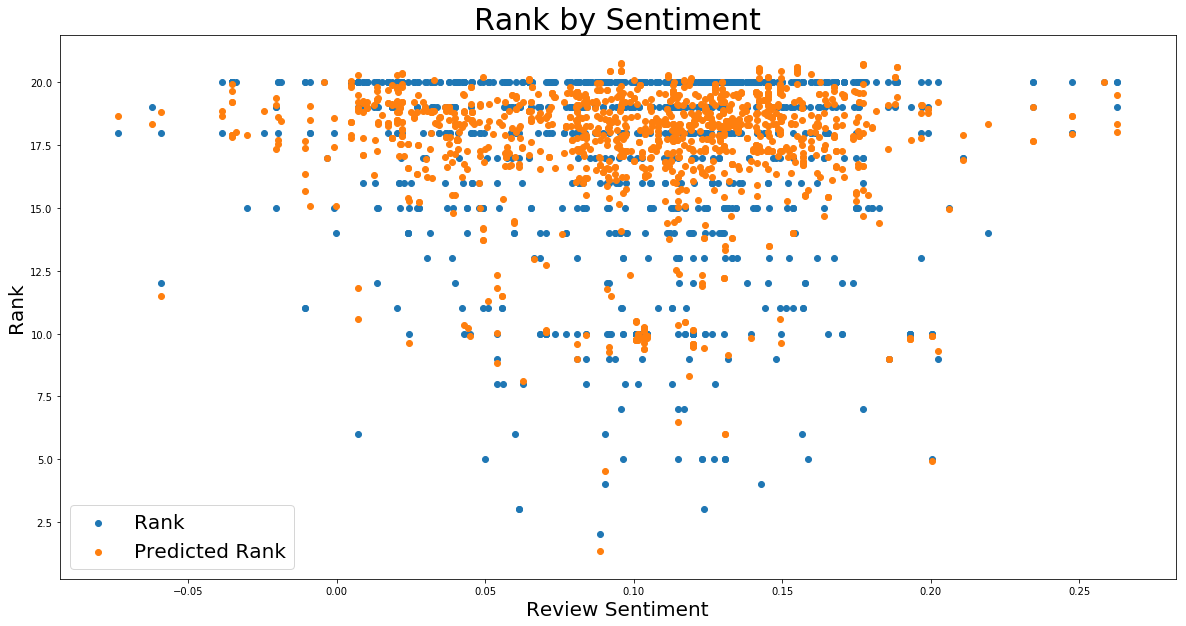

In [217]:
plt.figure(figsize = (20,10));
plt.scatter(x=df_dummy['sentiment'], y=df_dummy['rank'],label = 'Rank');
plt.scatter(x=df_dummy['sentiment'], y=df_dummy['pred_rank'], label = 'Predicted Rank')
plt.ylabel('Rank', fontsize = 20);
plt.xlabel('Review Sentiment', fontsize = 20);
plt.title('Rank by Sentiment', fontsize = 30);
plt.legend(fontsize = 20);

### Linear Regression with Cross Validation

(0.35768845221349266, 0.49259397037725017)
(0.3646729138465862, 0.47056308694233956)
(0.35293042919633166, 0.46606595963483216)
(0.3286818542553839, 0.512622268515666)
(0.37809769523993797, 0.43673542804454346)
(0.31135697123172124, 0.45033537032894566)
(0.28803572793768695, 0.5027539462632322)
(0.3120122935310058, 0.46802018539265794)
(0.28515066662575583, 0.5431212051120515)
(0.31500218753449727, 0.5151556926518865)


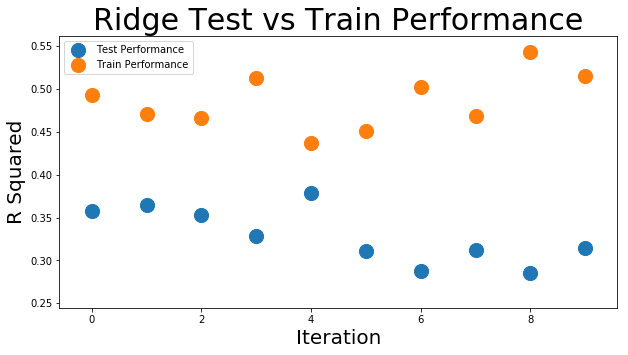

In [260]:
def lr_performance(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    lr = Ridge(fit_intercept=True, 
               normalize=True)
    lr.fit(X_train, y_train)
    return lr.score(X_test, y_test), lr.score(X_train, y_train)

def lr_test_train_iterations(X,y,z=10): 
    train_list = []
    test_list = []
    for i in range(z):
        result = lr_performance(X,y)
        print(result)
        train_list.append(result[1])
        test_list.append(result[0])
    plt.figure(figsize = (10,5));
    plt.scatter(x=[x for x in range(z)], 
            y=test_list,
            s=200,
            label = 'Test Performance')
    plt.scatter(x=[x for x in range(z)], 
             y=train_list,
             s=200,
             label = 'Train Performance')
    plt.ylabel('R Squared', fontsize = 20);
    plt.xlabel('Iteration', fontsize = 20);
    plt.title('Ridge Test vs Train Performance', fontsize = 30);
    plt.legend(fontsize = 10);

lr_test_train_iterations(X,y,10)

Clearly our model is very overfit, given the very poor performance of the test scores, compared with the train scores

### Get Top Coefficients

In [251]:
lr = Ridge(fit_intercept=True, 
           normalize=True)
lr.fit(X, y)

pd.DataFrame(sorted(zip(X.columns,[abs(x) for x in lr.coef_]),key = lambda x: x[1], reverse=True)[:10])\
            .rename(columns={0:'Feature',
                             1:'Absolute Coefficient'})
    

,Feature,Absolute Coefficient
0,list_title_Young Adult E-Book,6.269126
1,list_title_Espionage,6.091553
2,publisher_Phoenix,6.019397
3,list_title_Health,4.814907
4,list_title_Childrens Middle Grade E-Book,4.567228
5,list_title_Audio Nonfiction,3.350806
6,list_title_Hardcover Graphic Books,3.313664
7,list_title_Paperback Graphic Books,3.242040
8,publisher_Atheneum,3.210390
9,list_title_Paperback Books,3.135306


### Random Forest Regresssion with Cross Validation

(0.4932370841133662, 0.9032958303539445)
(0.6003758049617313, 0.8935112336989367)
(0.5403017818834182, 0.8721809939212336)
(0.457324302393088, 0.9049997415388936)
(0.496354370636934, 0.8942676859978504)
(0.5381943127199256, 0.8745152629328773)
(0.4810889856603941, 0.9029585737612951)
(0.4527999034281071, 0.8955354878776549)
(0.45426743169065986, 0.8903103350115409)
(0.5107274546650129, 0.8957057687513974)


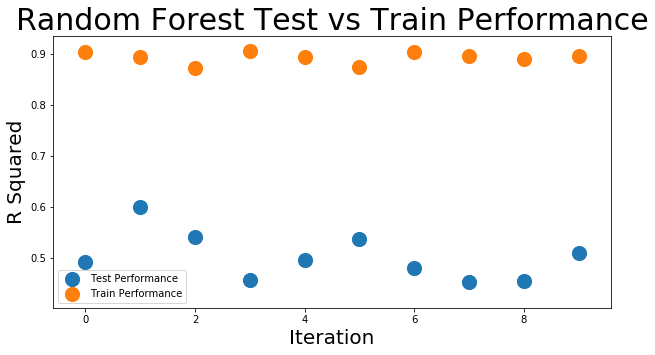

In [258]:
def rf_performance(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rand_forest = RandomForestRegressor(n_estimators=5, 
                                        min_samples_split=2)
    rand_forest.fit(X_train, y_train)
    return rand_forest.score(X_test, y_test), rand_forest.score(X_train, y_train)

def rf_test_train_iterations(X,y,z=10): 
    train_list = []
    test_list = []
    for i in range(z):
        result = rf_performance(X,y)
        print(result)
        train_list.append(result[1])
        test_list.append(result[0])
    plt.figure(figsize = (10,5));
    plt.scatter(x=[x for x in range(z)], 
            y=test_list,
            s=200,
            label = 'Test Performance')
    plt.scatter(x=[x for x in range(z)], 
             y=train_list,
             s=200,
             label = 'Train Performance')
    plt.ylabel('R Squared', fontsize = 20);
    plt.xlabel('Iteration', fontsize = 20);
    plt.title('Random Forest Test vs Train Performance', fontsize = 30);
    plt.legend(fontsize = 10);
    
rf_test_train_iterations(X,y,10)

### Feature Importances

In [198]:
rand_forest = RandomForestRegressor(n_estimators=5, min_samples_split=2)
rand_forest.fit(X, y)
sorted(zip(X.columns,rand_forest.feature_importances_),key = lambda x: x[1], reverse=True)[:10]

[('weeks_on_list', 0.19092363717439054),
 ('list_title_Picture Books', 0.15544058207102357),
 ('sentiment', 0.0933541439338909),
 ('list_title_Trade Fiction Paperback', 0.03995555132990822),
 ('list_title_Paperback Nonfiction', 0.03782847910356414),
 ('list_title_Hardcover Graphic Books', 0.0287257122778387),
 ('list_title_Audio Nonfiction', 0.027813340932066645),
 ('list_title_Young Adult', 0.024542283475125045),
 ('list_title_E-Book Nonfiction', 0.024452970195508225),
 ('publisher_Houghton Mifflin Harcourt', 0.022722627377493955)]

### Add Amazon Ranking Information

In [199]:
amazon_rank_df = pd.read_csv('masterrankings.csv',
                            usecols=[1,2,3,4,5])

### Merge Data with Original Dataframe

In [176]:
merge_df = pd.merge(amazon_rank_df,
             final_df,
             right_on='primary_isbn10',
             left_on='ASIN',
             how='left').dropna(subset=['sentiment'])

In [200]:
len(merge_df)

1600

We have only 38 unique samples, but let's run the models on htis set anyway!

In [201]:
len(merge_df['ASIN'].unique())

38

In [202]:
merge_df.columns

Index(['ASIN', 'max_rank', 'min_rank', 'GROUP', 'FORMAT', 'Unnamed: 0', 'rank',
       'rank_last_week', 'weeks_on_list', 'asterisk', 'dagger',
       'primary_isbn10', 'primary_isbn13', 'publisher', 'description', 'price',
       'title', 'author', 'contributor', 'contributor_note', 'book_image',
       'book_image_width', 'book_image_height', 'amazon_product_url',
       'age_group', 'book_review_link', 'first_chapter_link',
       'sunday_review_link', 'article_chapter_link', 'list_title', 'list_date',
       'review_text', 'sentiment', 'review_length'],
      dtype='object')

### Fit Regression Model and Get R^2 and Adjusted R^2

In [256]:
model_df2 = merge_df[['rank',
                      'GROUP', 
                      'FORMAT',
                      'weeks_on_list',
                      'publisher',
                      'list_title',
                      'sentiment',
                      ]]

df_dummy2 = pd.get_dummies(model_df2, 
                          drop_first=False, 
                          columns=['publisher',
                                  'GROUP', 
                                  'FORMAT',
                                  'list_title'])

stats_model2 = LinearRegression(fit_intercept=True, normalize = True)
X2 = df_dummy2.drop(labels=['rank'],
                  axis=1)
y2 = df_dummy2['rank'] 
stats_model2.fit(X2, y2)
df_dummy2['pred_rank'] = stats_model2.predict(X2)
stats_model2.score(X2, y2), 1 - (1-stats_model2.score(X2, y2))*(len(y2)-1)/(len(y2)-X2.shape[1]-1)

(0.23627385442155513, 0.20804273230873327)

(0.09303287009779648, 0.15956900438226884)
(0.10190623428312227, 0.136712889500906)
(0.11162852892910757, 0.14309497269925253)
(0.10188990169784706, 0.15462781395878267)
(0.07029997589235837, 0.16806770028670948)
(0.10417794653221368, 0.14740933692532965)
(0.11152728087385066, 0.13721299561396638)
(0.10289341924273454, 0.13807810512987306)
(0.09690644099311786, 0.1677928590979697)
(0.11436726166880096, 0.15481604910025792)


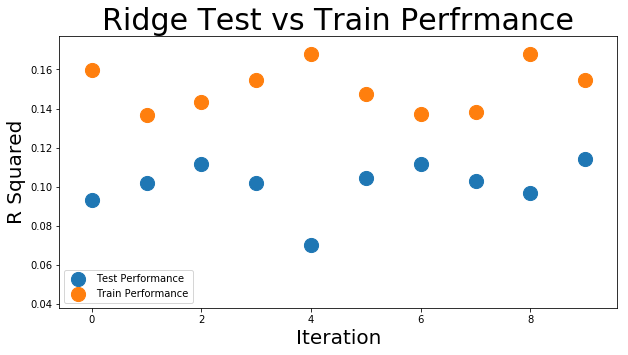

In [259]:
lr_test_train_iterations(X2,y2,10)

(0.602691328968469, 0.80746946238131)
(0.6424179832938608, 0.813457480756743)
(0.6071669165409795, 0.821585553777947)
(0.620447614752901, 0.8101594982368194)
(0.6098912740433335, 0.8103998864896879)
(0.645709402849295, 0.8168461262377893)
(0.6634203366238645, 0.8065404898101973)
(0.6777000834072202, 0.8152870058621252)
(0.5952023645659583, 0.7972797040891859)
(0.6491923357573325, 0.7951511135158702)


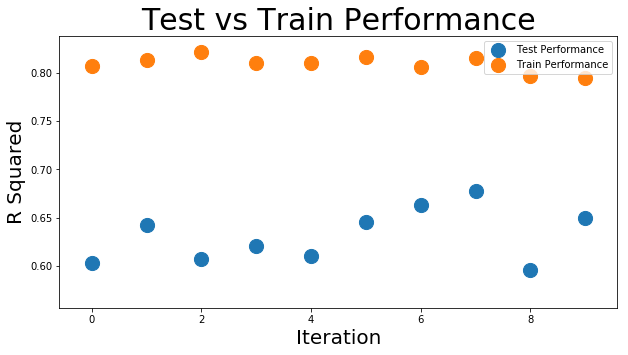

In [225]:
rf_test_train_iterations(X2,y2,10)

In [252]:
rand_forest2 = RandomForestRegressor(n_estimators=5, min_samples_split=2)
rand_forest2.fit(X2, y2)
pd.DataFrame(sorted(zip(X2.columns,rand_forest2.feature_importances_),key = lambda x: x[1], reverse=True)[:10])\
            .rename(columns={0:'Feature',
                             1:'Importance'})
             

,Feature,Importance
0,weeks_on_list,0.415248
1,sentiment,0.161268
2,list_title_Hardcover Nonfiction,0.080255
3,list_title_Combined Print and E-Book Nonfiction,0.034279
4,list_title_Hardcover Fiction,0.032335
5,list_title_Combined Print Fiction,0.029445
6,FORMAT_paperback,0.029383
7,publisher_Random House,0.028487
8,publisher_Scribner,0.019365
9,list_title_Hardcover Business Books,0.016027


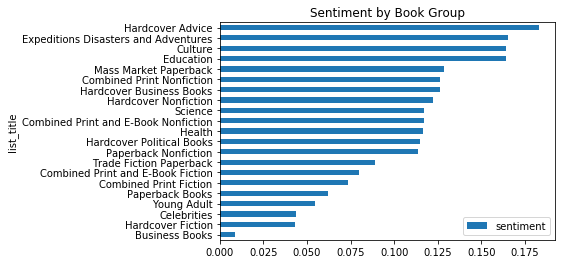

In [215]:
merge_df.groupby('list_title').agg({'sentiment':'mean'})\
                              .sort_values(by='sentiment')\
                              .plot(kind='barh',
                                    title='Sentiment by Book Group'
                                    
                              );